# Product Clustering : a geographical analysis
In this notebook answer the following questions:

1. Are similar areas in terms of typical products geographically close?
2. Can we naturally cluster areas geographically when it comes to food consumption in London?
3. How do those clusters differ when we vary the aggregation level?
4. In the context of an advertising campaign, which areas of the city should be associated with which kind of products?

We will start by studing the ouput clustering of a K-means algorithm to undertand which values of $k$ will produce the most natural clustering __*in the typical product space*__. We will then try to make some sense of out this clustering by performing a vizualization in 2D using several dimentionality reduction techniques. We might hope that we will already be able to see some geographical structure in those plots (recognize somehow the map of London). If not we will have to apply other techniques to help access the geographical validation of the clusters, if any.

In [1]:
import pandas as pd
%matplotlib inline
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

## Data Loading 
To be as precise as possible we study the smallest aggregation level for the entire year period.

In [2]:
data_path="./data/"
data = pd.read_csv(data_path+'tesco.csv',index_col='area_id')
data = data.query('month=="yea" and agg_level=="lsoa"')\
            .drop(columns=['month','agg_level'])
data.head()

,fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutrients_calories
area_id,,,,,,,,
E01000001,8.535149,3.498749,9.213734,5.262429,15.158014,1.622653,163.985327,1.620439
E01000002,8.054729,3.159077,8.337412,5.351774,14.358466,1.692822,157.572172,1.661276
E01000003,8.153757,3.375788,9.414937,5.029519,15.820254,1.522523,163.321285,1.646243
E01000005,8.339058,3.319496,9.603258,5.230254,17.126487,1.612862,169.339310,1.595496
E01000006,9.622101,3.864007,11.355115,5.026295,19.903063,1.640227,190.310015,1.519193


In [4]:
kmean = KMeans(n_clusters=2, random_state=42).fit(data)

In [5]:
silhouettes = []
# Try multiple k
for k in range(2, 11):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(data)
    # Get the Silhouette score
    score = silhouette_score(data, labels)
    silhouettes.append({"k": k, "score": score})
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)
sse = []
for k in range(1, 10):
    # Assign the labels to the clusters
    kmeans = KMeans(n_clusters=k, random_state=10).fit(data)
    sse.append({"k": k, "sse": kmeans.inertia_})
sse = pd.DataFrame(sse)

/Users/lucas_gruaz/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/lucas_gruaz/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


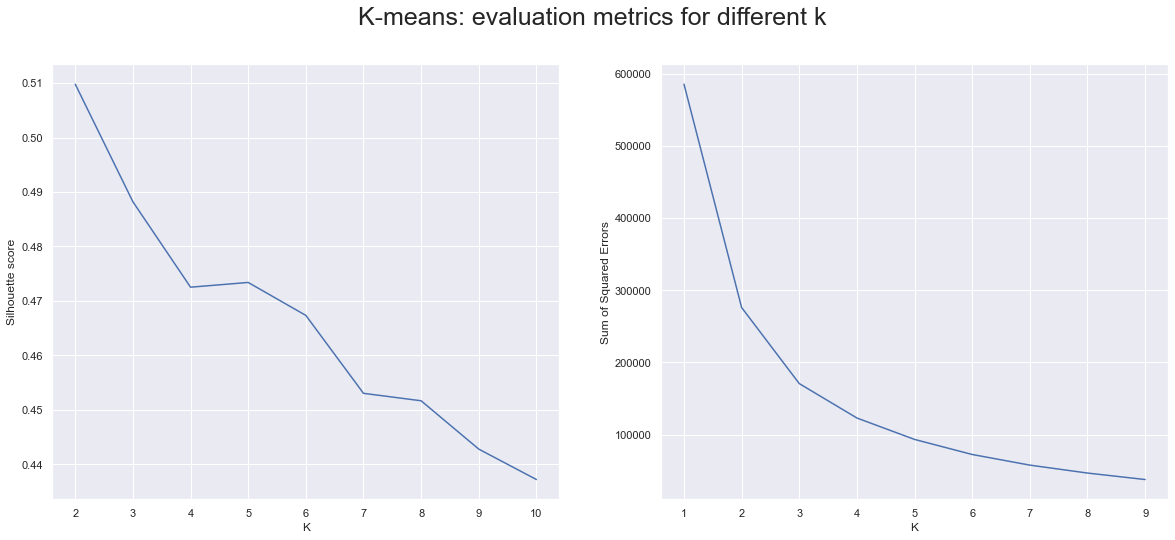

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(20,8))
# Plot the data
plt.subplot(121)
sns.lineplot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
# Plot the data
plt.subplot(122)
sns.lineplot(sse.k, sse.sse)
plt.xlabel("K")
plt.ylabel("Sum of Squared Errors")
fig.suptitle("K-means: evaluation metrics for different k",fontsize=25)
plt.show()

In [8]:
k=4
X_reduced_pca  = PCA(n_components=2).fit(data).transform(data)
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(data)

/Users/lucas_gruaz/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/lucas_gruaz/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


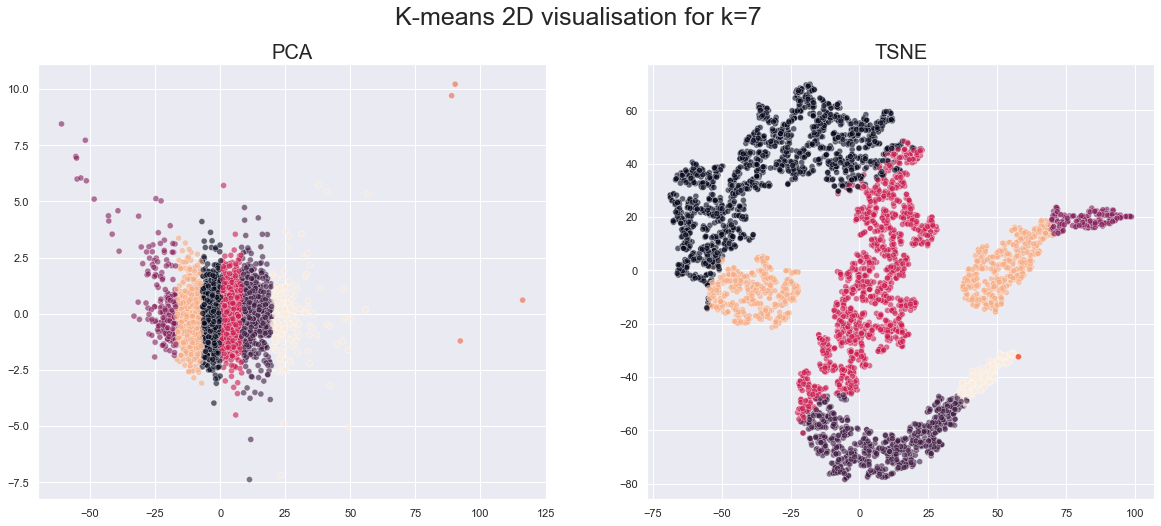

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(20,8))
labels = KMeans(n_clusters=k, random_state=42).fit_predict(data)
plt.subplot(121)
ax = sns.scatterplot(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6)
ax.set_title("PCA",fontsize=20)
plt.subplot(122)
ax = sns.scatterplot(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
ax.set_title("TSNE",fontsize=20)
fig.suptitle("K-means 2D visualisation for k=7",fontsize=25)
plt.show()

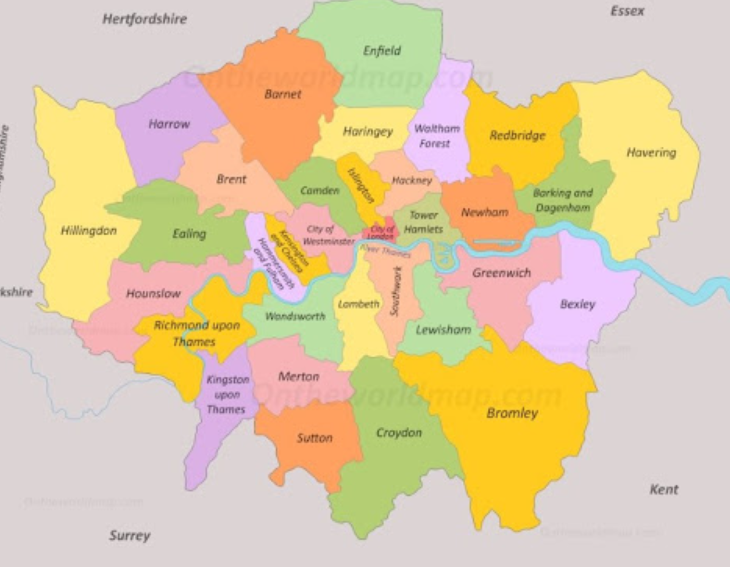

Unfortuna

# Write back  dataset with clusters

In [10]:
df=pd.read_csv('data/tesco.csv') 
max_k=8
agg_levels=np.unique(df['agg_level'])
typical_products=[ 'fat', 'saturate', 'sugar', 'protein', 'carb', 'fibre','energy_tot', 'h_nutrients_calories']
for k in range(2,max_k+1):
    new_col_name='cluster_'+str(k)
    df[new_col_name]='No data'
df.head(1)

,area_id,fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutrients_calories,month,agg_level,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,E09000001,8.472985,3.361599,9.278065,5.253333,15.779639,1.61985,165.851751,1.618208,yea,borough,No data,No data,No data,No data,No data,No data,No data


In [11]:
for lvl in agg_levels:
    current_data=df[(df.month == 'yea') * (df.agg_level ==lvl)]
    for k in range(2,max_k+1):
        labels = KMeans(n_clusters=k, random_state=42).fit_predict(current_data[typical_products])
        col_name='cluster_'+str(k)
        df.loc[current_data.index,col_name]=labels


/Users/lucas_gruaz/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/lucas_gruaz/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/lucas_gruaz/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/lucas_gruaz/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Py

In [12]:
df.to_csv('data/tesco_cluster.csv',index=False)

# Cluster analysis

In [13]:
def add_clusters(gdf):
    cols = [c for c in df.columns if c.startswith("cluster")]
    out = gdf.merge(df[['area_id']+cols],on='area_id',how='inner').query("cluster_2 != 'No data'")
    out[cols] = out[cols].astype('int')
    out = out.reset_index()
    for k in range(2,max_k +1):
        out['cluster_random_'+str(k)] = np.random.randint(k, size=len(out))
    return out

In [14]:
import pandas as pd
import geopandas as gpd
import numpy as np
data_path = 'data/statistical-gis-boundaries-london/ESRI2/'
gdf_lsoa = gpd.read_file(data_path + 'LSOA_2011_London_gen_MHW.shp' )[['LSOA11CD','geometry']]\
                .rename(columns={'LSOA11CD':'area_id'})
gdf_lsoa = gdf_lsoa.reset_index()
gdf = add_clusters(gdf_lsoa)
gdf.head(4)

,level_0,index,area_id,geometry,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_random_2,cluster_random_3,cluster_random_4,cluster_random_5,cluster_random_6,cluster_random_7,cluster_random_8
0,2,0,E01000001,"POLYGON ((532105.092 182011.230, 532162.491 18...",0,2,2,2,5,2,2,0,0,0,0,1,4,7
1,15,1,E01000002,"POLYGON ((532746.813 181786.891, 532671.688 18...",0,2,2,2,5,2,2,0,2,0,3,5,5,2
2,28,2,E01000003,"POLYGON ((532135.145 182198.119, 532158.250 18...",0,2,2,2,5,2,2,1,0,3,4,2,5,5
3,41,3,E01000005,"POLYGON ((533807.946 180767.770, 533649.063 18...",0,2,2,4,2,5,0,0,1,1,1,3,6,5


## Comparaison random graph

In [20]:
def add_neighbors_clusters(gdf):
    cols = [c for c in gdf.columns if c.startswith("cluster")]
    l = [None] *len(gdf)
    for idx, row in tqdm(gdf.iterrows(), total=len(gdf.index)):
        neighbors = gdf[~gdf.geometry.disjoint(row.geometry)][['area_id']+cols]\
            .query("area_id != '"+str(row.area_id)+"'")[cols]
        l[idx] = np.sum(neighbors == row[cols])
    
    tmp = pd.concat(l,axis=1).T.rename(
        columns={c:'cluster_border_neighbors_'+("random_" if c.find('random')!=-1 else "")+c[-1] 
                 for c in cols})
    return pd.concat((gdf,tmp),axis=1)

In [21]:
neighbors = add_neighbors_clusters(gdf)

100%|██████████| 4833/4833 [01:53<00:00, 42.60it/s]


In [22]:
def create_border_scores(gdf):
    l = []
    for k in range(2,max_k+1):
        # mean border scores
        col       = "cluster_"+str(k)
        score_col = "cluster_border_neighbors_" + str(k)
        sdf = gdf.groupby(col)[score_col].mean()\
            .drop(columns=['index'])\
            .rename('mean_border_score_'+str(k))
        # random assignment
        random_col       = 'cluster_random_'+str(k)
        random_score_col = "cluster_border_neighbors_random_" + str(k)
        random_mean      = gdf.groupby(random_col)[random_score_col]\
                                .mean()\
                                .mean()
        #create output pd series
        l.append(sdf.append(pd.Series({'random':random_mean})))
    out = pd.concat(l,axis=1)
    out = out.rename(columns={c:"cluster_"+str(int(c)+2) for c in out.columns})
    out.index = out.index.astype(str)
    return out.sort_index()

In [23]:
mean_borders = create_border_scores(neighbors)
mean_borders.to_csv('data/mean_border_score.csv',index=False)
mean_borders

,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,4.283726,3.545064,3.275125,2.734783,2.568956,2.360133,2.444638
1,3.388767,2.537017,2.526681,0.821429,1.398964,2.008264,1.797557
2,NaN,3.139927,2.730583,2.157480,2.683307,1.980769,2.089005
3,NaN,NaN,1.302452,2.278826,0.000000,2.179195,1.815962
4,NaN,NaN,NaN,2.840268,2.043400,0.000000,0.866242
5,NaN,NaN,NaN,NaN,2.129450,2.235294,2.280161
6,NaN,NaN,NaN,NaN,NaN,0.906977,0.000000
7,NaN,NaN,NaN,NaN,NaN,NaN,2.153846
random,2.795813,1.851411,1.400247,1.106636,0.927410,0.768110,0.667628


##  Visualisation

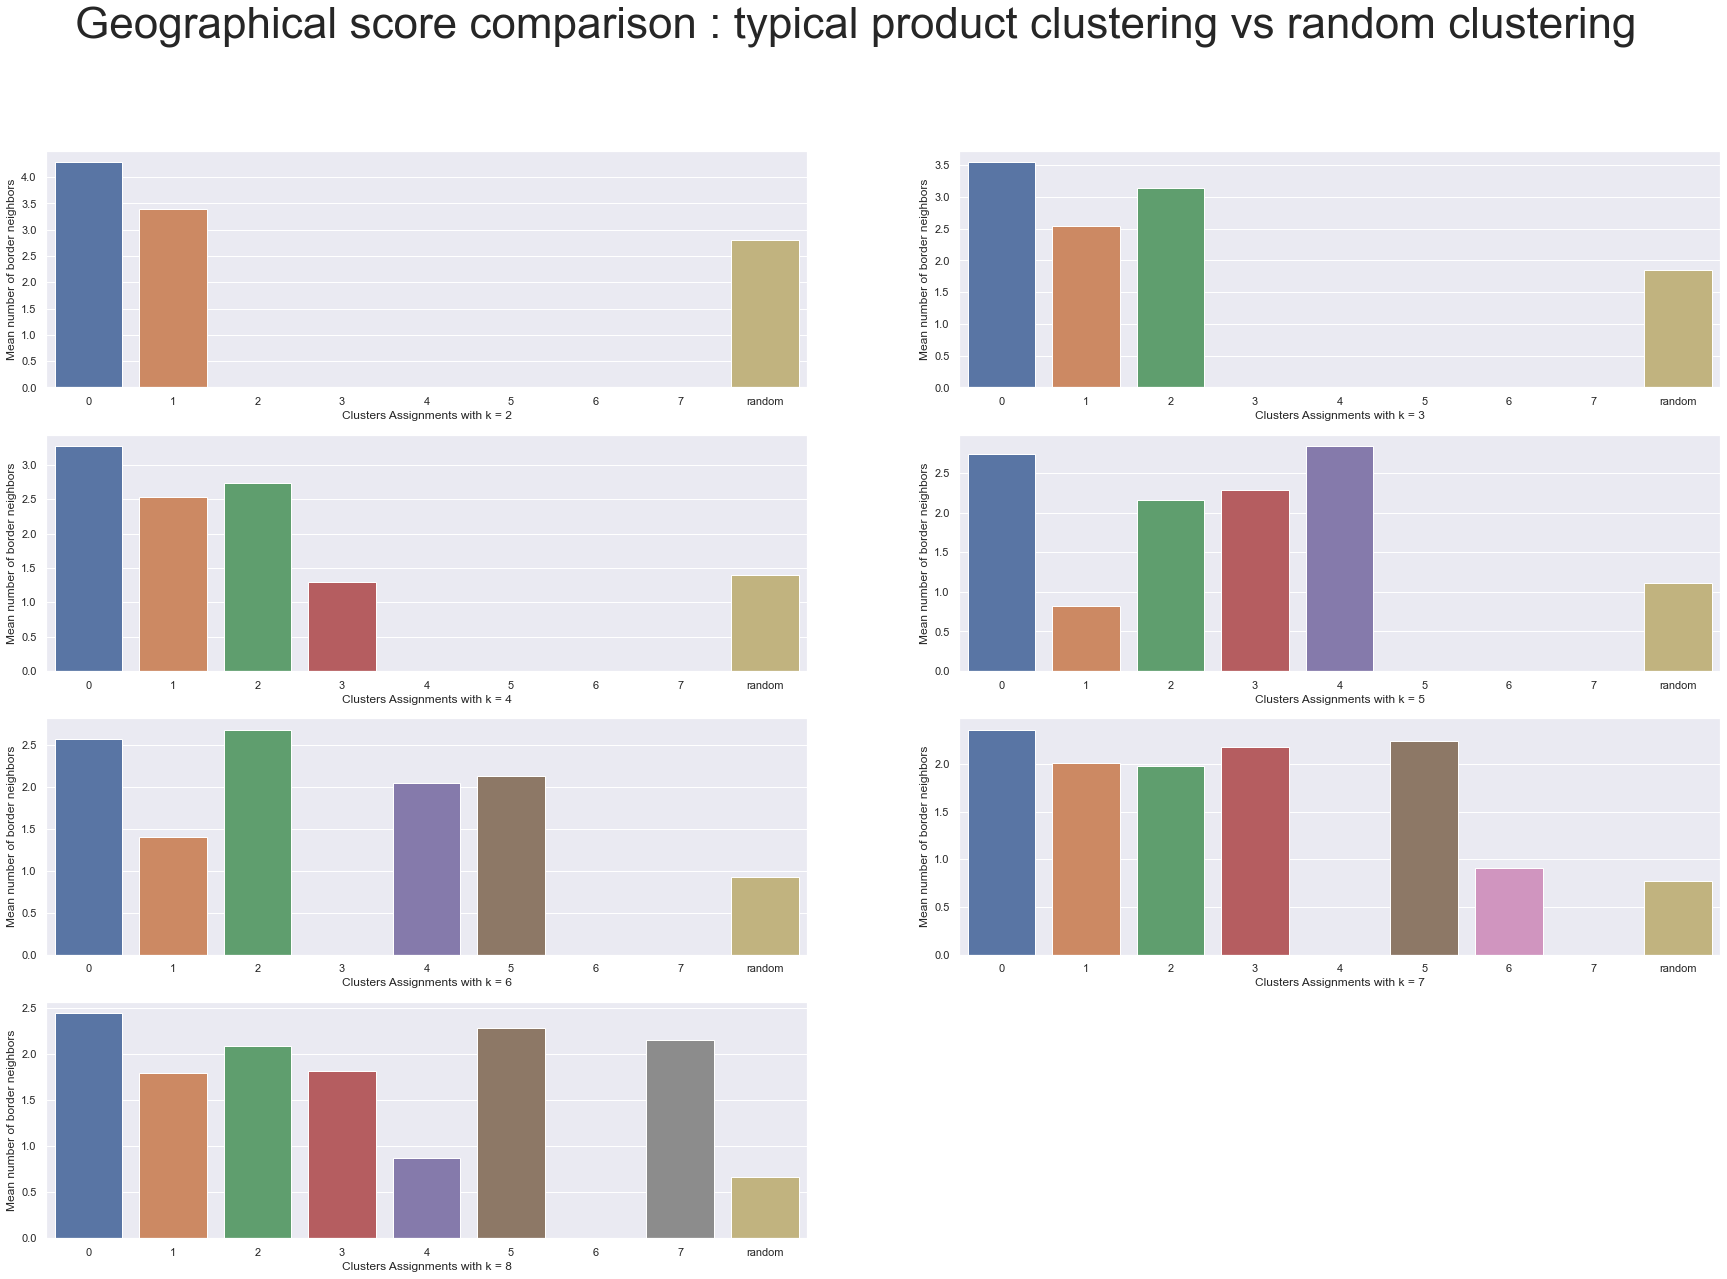

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(30,20))
for i in range(1,8):
    plt.subplot(4,2,i)
    ax = sns.barplot(x = mean_borders.index, y="cluster_"+str(i+1),data=mean_borders)
    ax.set_xlabel("Clusters Assignments with k = "+str(i+1))
    ax.set_ylabel("Mean number of border neighbors")
    #g.add_legend()
fig.suptitle("Geographical score comparison : typical product clustering vs random clustering", fontsize=44)
plt.show()

## Geographic silhouette

In [25]:
geo_coords  = gdf_lsoa.geometry.centroid.apply(lambda p: pd.Series({'x':p.x,'y':p.y}))
geo_coords['area_id'] = gdf_lsoa.area_id
geo_coords  = geo_coords.merge(data,on='area_id',how='inner')[['x','y']]
silhouettes = []
# Try multiple k
for k in range(2, 20):
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(data)
    # Get the Silhouette score
    geo_score  = silhouette_score(geo_coords, labels)
    silhouettes.append({"k": k, "geo_score": geo_score, "Clustering Type":"k-means"})
    #random graph comparison
    rnd_score = silhouette_score(geo_coords, np.random.randint(k, size=len(labels)))
    silhouettes.append({"k": k, "geo_score": rnd_score, "Clustering Type":"random"})
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)
silhouettes.head(3)

,k,geo_score,Clustering Type
0,2,0.102800,k-means
1,2,-0.000110,random
2,3,-0.028515,k-means


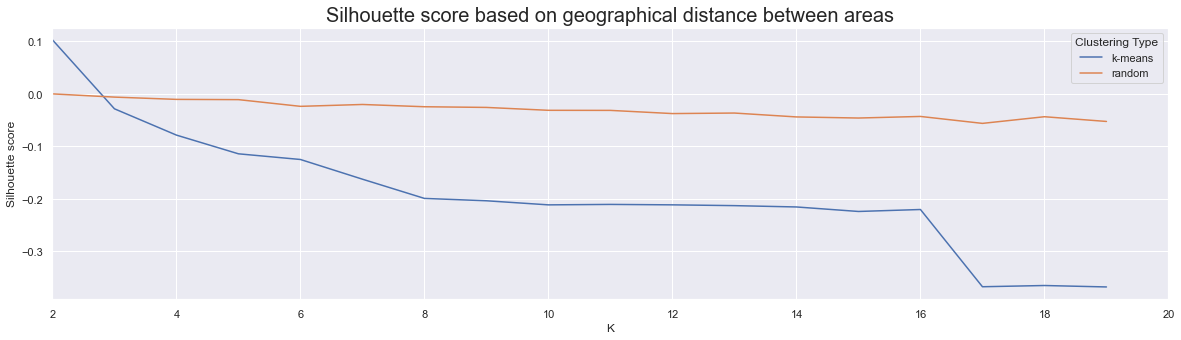

In [26]:
plt.figure(figsize=(20,5))
# Plot the data
ax = sns.lineplot(data=silhouettes, x='k', y='geo_score', hue="Clustering Type")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
ax.set_xlim((2,20))
plt.title("Silhouette score based on geographical distance between areas",fontsize=20)
plt.show()

# Graph analysis

We will now try a different approach to evaluate our clustering. We will create a graph where each area is a node, and there's an edge between every adjacent areas (areas with a common border). Then we will compute the shortest path length for every pair of nodes, and use it as a distance metric for a new silhouette analysis.

First, we load the data.

In [39]:
df=pd.read_csv('data/tesco_cluster.csv')
df_lsoa = df.query('agg_level == "lsoa"').query('month == "yea"')
df_lsoa.head()

,area_id,fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutrients_calories,month,agg_level,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
13718,E01000001,8.535149,3.498749,9.213734,5.262429,15.158014,1.622653,163.985327,1.620439,yea,lsoa,0,2,2,2,5,2,2
13719,E01000002,8.054729,3.159077,8.337412,5.351774,14.358466,1.692822,157.572172,1.661276,yea,lsoa,0,2,2,2,5,2,2
13720,E01000003,8.153757,3.375788,9.414937,5.029519,15.820254,1.522523,163.321285,1.646243,yea,lsoa,0,2,2,2,5,2,2
13721,E01000005,8.339058,3.319496,9.603258,5.230254,17.126487,1.612862,169.339310,1.595496,yea,lsoa,0,2,2,4,2,5,0
13722,E01000006,9.622101,3.864007,11.355115,5.026295,19.903063,1.640227,190.310015,1.519193,yea,lsoa,1,1,1,3,4,1,1


Then we compute the list of neighbors for every area, and store it in the dataframe.

In [40]:
def add_neighbors_list(gdf):
    """
    Compute the list of neighboring areas for every area in the given dataframe, and store it in the dataframe
    @gdf : Geopandas dataframe that contains every areas and their geometrical information in a column named 'geometry'
    return : augmented dataframe
    """
    l = []
    for idx, row in tqdm(gdf.iterrows(), total=len(gdf.index)):
        neighbors = gdf[~gdf.geometry.disjoint(row.geometry)][['area_id']]\
            .query("area_id != '"+str(row.area_id)+"'").area_id.values
        l.append(neighbors)
    gdf["border_neighbors"] = l
    return gdf

In [29]:
gdf_lsoa_neighbors = add_neighbors_list(gdf_lsoa.merge(4['area_id'], how='inner', on='area_id'))

100%|██████████| 4833/4833 [01:37<00:00, 49.34it/s]


In [41]:
# Keep only columns of interest for the graph
gdf_lsoa_edges = gdf_lsoa_neighbors[['area_id', 'border_neighbors']]
gdf_lsoa_edges.head()

,area_id,border_neighbors
0,E01000001,"[E01000002, E01000003, E01032739, E01032740, E..."
1,E01000002,"[E01000001, E01000003, E01002704, E01032739]"
2,E01000003,"[E01000001, E01000002, E01002704, E01002706, E..."
3,E01000005,"[E01004293, E01004294, E01004310, E01032739, E..."
4,E01000006,"[E01000009, E01000044, E01000068, E01000071]"


In [31]:
# Flatten the lists to put the dataframe in a networkx-friendly form
edges = pd.DataFrame([[gdf_lsoa_edges.area_id[i], x] 
               for i, y in gdf_lsoa_edges['border_neighbors'].iteritems() 
                    for x in y], columns=['area_id', 'neighbor'])
edges.head()

,area_id,neighbor
0,E01000001,E01000002
1,E01000001,E01000003
2,E01000001,E01032739
3,E01000001,E01032740
4,E01000001,E01033490


We can now create the graph and compute the pairwise shortest path lengths.

In [42]:
import networkx as nx

# Create graph from edge list, using columns area_id annd neighbor
G = nx.from_pandas_edgelist(edges, 'area_id', 'neighbor')

# Compute shortest path length for every pair of nodes in the graph
shortest_path_len = dict(nx.shortest_path_length(G))

# Put it in a matrix
distance_matrix = pd.DataFrame(shortest_path_len)

# Sort the rows and columns so that they are in the same order (i.e there are zeros in the diagonal)
distance_matrix = distance_matrix[df_lsoa['area_id']].sort_index()
distance_matrix.head()

,E01000001,E01000002,E01000003,E01000005,E01000006,E01000007,E01000008,E01000009,E01000010,E01000011,...,E01033737,E01033738,E01033739,E01033740,E01033741,E01033742,E01033743,E01033744,E01033745,E01033746
E01000001,0,1,1,2,22,21,20,21,20,22,...,25,20,29,28,29,27,29,27,30,17
E01000002,1,0,1,2,22,21,20,21,20,22,...,25,20,29,28,29,27,29,27,30,17
E01000003,1,1,0,3,23,22,21,22,21,22,...,26,21,30,29,30,28,30,28,31,18
E01000005,2,2,3,0,21,20,19,20,19,21,...,25,20,29,28,29,27,29,27,30,17
E01000006,22,22,23,21,0,2,3,1,2,2,...,45,40,49,48,49,47,49,47,50,37


Having this matrix, we can now calculate the silhouette score of the K-means clustering using our new metric.

In [38]:
score = silhouette_score(X=distance_matrix.astype(float), labels=df_lsoa['cluster_2'], metric="precomputed")
score

0.0727654496701839

# Changer en dessous !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [44]:
silhouettes = []
for k in range(2, 9):
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(data)
    # Get the Silhouette score
    graph_score  = silhouette_score(X=distance_matrix.astype(float), labels=df_lsoa['cluster_'+str(k)], metric="precomputed")
    silhouettes.append({"k": k, "graph_score": graph_score, "Clustering Type":"k-means"})
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)
silhouettes.head(3)

,k,graph_score,Clustering Type
0,2,0.072765,k-means
1,3,-0.019171,k-means
2,4,-0.058361,k-means


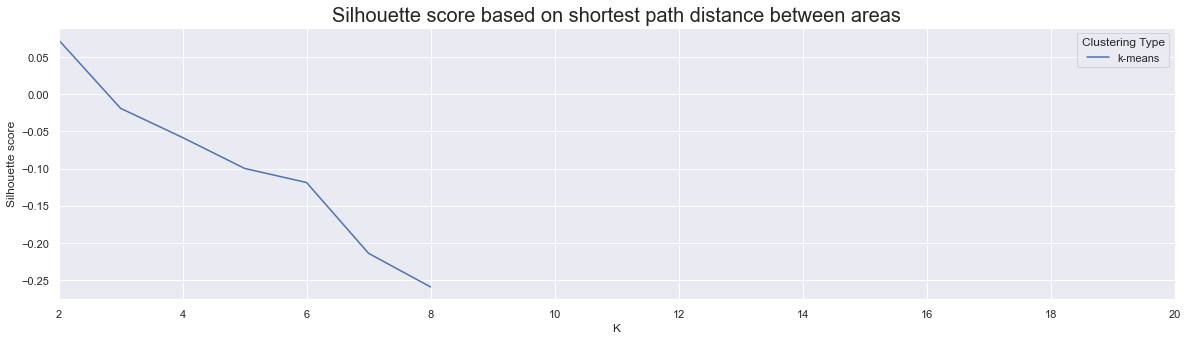

In [45]:
plt.figure(figsize=(20,5))
# Plot the data
ax = sns.lineplot(data=silhouettes, x='k', y='graph_score', hue="Clustering Type")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
ax.set_xlim((2,20))
plt.title("Silhouette score based on shortest path distance between areas",fontsize=20)
plt.show()